# OUTLINE 

## Step 1
#### Determine datasets to be included

_____________
_____________
Financial Metrics:
- BTC/ETH/DODGE price and volume
- (?) BTC OI - aggregated open interest 
- (?) BTC funding rate - aggregated funding rate
- In/Out of Money:
  - ITM = # of addresses where average cost of btc < current price 
  - OTM = # of addresses where average cost of btc > curent price
- MV Ratio: market value to realized value ratio
  - measures the ratio of marketcap to the average purchasing cost of each address
  - high MV ratio suggests current marketcap significantly exceeds average purchase cost of most holders, indicating most holders are in profit 
_____________
_____________
Mining Metrics:
- Hash Rate
- Inflows/outflows
- Netflows
- Reserves 
- Difficulty
_____________
_____________
Network Metrics:
- Total Addresses 
- New Adoption Rate
- Daily active addresses
- Activity to Fee Ratio
- Total Transactions
- Total Fees
- Transaction Volume
- Large holder netflows 
_____________
_____________
Exchange Metrics:
- CEX netflows 
- CEX inflows
- CEX outflows
_____________
_____________
Economic Metrics:
-  ...(?)
-  ...(?)
_____________
_____________
Sentiment Analysis Metrics:
-  ...(?)
-  ...(?)
_____________
_____________

## Step 2
### Data preprocessing and Feature Engineering

_____________
_____________
Data cleaning:
- Handle missing values
  - imputation
  - forward/backward filling
- Identify and remove Outlliers
- Noise reduction 
_____________
Feature Engineering:
- Decompose Timestamps
- Lagged features
- Rolling Window statistics
- TA indicators
_____________
Data Transformation:
- Normalize/Standardize data
- Differencing
_____________
_____________
Sequence Creation:
- Fixed Window Sequencing: Transform the time series data into sequences that the LSTM can process.
- Overlap: You can choose to have overlapping windows (e.g., shift one time step for the next sequence) to increase the density of the training data
_____________
Train/Test Split:
- Ensure that the split between training and testing data respects the temporal order of observations
- Avoid random splits as they can introduce future leakage into the training set
_____________
Batch Size and Sequence Padding:
- Batch Size: Opt for a smaller batch size if you encounter memory issues or if you want to potentially benefit from the noise added by stochastic gradient descent during trainin
- Padding: If using batches, ensure all sequences in a batch are of the same length through padding. However, be mindful of how much padding you add as excessive padding can dilute the signal with noise
_____________
Robust Validation Strategy:
- Time Series Cross-Validation: Use techniques like forward chaining, where successive training sets are supersets of those that come before them. This mimics real-world scenarios and provides a robust estimate of the model’s performance
_____________
_____________


## Step 3
### Model Build and Evaluation 

_____________
_____________
Model Architecture:
- Number of Layers: Start with one or two LSTM layers. Increasing the number of layers can help the model learn more complex patterns but can also lead to overfitting and increased computational cost.
- Number of Units: The number of units in each LSTM layer should be chosen based on the complexity of the problem. More units can capture more complex structures but may also overfit.
- Bidirectional LSTMs: Consider using bidirectional LSTMs if the context from future steps provides useful information for the model.
_____________
Regularization:
- Dropout: Use dropout in LSTM layers to prevent overfitting. Typically, dropout is applied to the inputs and/or the recurrent connections of the LSTM units.
- Recurrent Dropout: This is a specific form of dropout used in LSTM layers to drop units in the recurrent connections, which can help in regularizing the model further.
_____________
Optimizer and Learning Rate:
- Optimizer: Common choices for LSTM models include Adam or RMSprop, as they are more capable of handling the vanishing gradient problem in long sequences compared to SGD (Stochastic Gradient Descent).
- Learning Rate: Choosing the right learning rate is crucial. Use learning rate schedules or adaptive learning rate methods like learning rate decay to optimize this parameter dynamically during training.
_____________
Loss Function:
- Choose the loss function according to the nature of your prediction task:
  - For regression tasks, mean squared error (MSE) or mean absolute error (MAE) are common.
  - For classification, binary cross-entropy (for binary classification) or categorical cross-entropy (for multi-class classification) are typical choices.
_____________
Training Strategies:
- Early Stopping: Use early stopping to halt training when the model's performance on a validation set stops improving, preventing overfitting.
- Gradient Clipping: This technique limits the size of the gradients to a defined range or norm, which can prevent the exploding gradient problem in LSTMs.
_____________
Evaluation:
- Use a separate validation set to tune the parameters of your LSTM model. It’s crucial to have a test set that has not been seen during the model development phase to evaluate the model's performance.
_____________
 Iterative Refinement:
- Continuously refine the model based on feedback from real-world use or additional validation, adjusting aspects like the architecture, training duration, and input features.
_____________
_____________

## Step 4
### Implement Boosted LSTM & Best Practices 

_____________
_____________
Base Model Training:
- Begin by training an initial LSTM model on the dataset.
- Compute the residuals or errors (difference between the predicted and actual values).
_____________
Sequential Training:
- Train additional LSTM models on the residuals of the previous models.
- Each model focuses on learning the patterns missed by its predecessors.
_____________
Aggregation of Predictions:
- Combine the predictions of all LSTM models, typically by weighted averaging, where weights can be determined based on the performance of each model on a validation dataset.
_____________
_____________

Model Complexity:
- Carefully choose the complexity of each LSTM in the ensemble. Too complex models might overfit, especially in later stages where the focus is on fitting residuals.
_____________
Learning Rate Adjustments:
- Adjust the learning rates for each subsequent LSTM. Later models might benefit from lower learning rates to fine-tune the predictions on residuals.
_____________
Regularization Techniques:
- Use dropout, recurrent dropout, and possibly L1/L2 regularization to prevent overfitting, especially since boosting can increase the risk of overfitting by focusing too narrowly on specific aspects of the dataset.
_____________
Early Stopping:
- Implement early stopping during training of each LSTM model to avoid overfitting on noise in the residuals.
_____________
Error Monitoring:
- Continuously monitor the error patterns; if subsequent models do not significantly improve the predictions, consider stopping the addition of new models to the ensemble.
_____________
Diverse Initialization:
- Initialize each LSTM model differently to promote model diversity, which is key to the success of ensemble methods.
_____________
_____________

# Load Data and Dependencies 

In [4910]:
#IMPORTS 
import os
import requests
import numpy as np
import pandas as pd
import hvplot.pandas
import datetime as dt
import yfinance as yf
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4911]:
#API REQUESTS

In [4912]:
#READ IN CSV DATA

#Financial Data 
btc_itm_otm = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/BTC_ITM_OTM.csv"), index_col='DateTime', infer_datetime_format=True, parse_dates=['DateTime'])
btc_mvrv_ratio = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/BTC_MV_Ratio.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_price = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/BTC_Price_Bitcoin.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
doge_price = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/DOGE_Price_Dogecoin.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
eth_price = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/ETH_Price_Ethereum.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
# Mining Data
btc_miner_hash_rate = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Mining Metrics/BTC_Hash_Rate.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_miner_reserves = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Mining Metrics/BTC_Miner_Reserves.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_miner_difficulty = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Mining Metrics/BTC_Mining_Difficulty.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_miner_netflows = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Mining Metrics/BTC_Miner Netflows.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
# Network Data 
btc_activity_fee_ratio = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_Activity To Fee Ratio.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_daily_active_addresses = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_Daily Active Addresses.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_new_adoption_rate = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_New Adoption Rate.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_total_addresses = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_Total Addresses.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_total_fees = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_Total Fees.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_toal_transactions = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_Total Transactions.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_transaction_volume = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_Transactions Volume.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
btc_large_holder_netflows = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Network Metrics/BTC_large_holders_netflows.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
# Exchange Data
btc_cex_netflows = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Exchange Metrics/BTC_CEX_Netflows.csv"), index_col="DateTime", infer_datetime_format=True, parse_dates=['DateTime'])
#Economic Data


/var/folders/jf/lcpt8z3d2gb1_qpgt0d_xdw00000gn/T/ipykernel_51733/2593487698.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  btc_itm_otm = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/BTC_ITM_OTM.csv"), index_col='DateTime', infer_datetime_format=True, parse_dates=['DateTime'])
/var/folders/jf/lcpt8z3d2gb1_qpgt0d_xdw00000gn/T/ipykernel_51733/2593487698.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  btc_mvrv_ratio = pd.read_csv(Path("/Users/TFitz/School/Project_2/Resources/Financial Metrics/BTC_MV_Ratio.csv"), inde

In [4913]:
# DATAFRAME & PLOT STORAGE

dataframes = []

feature_plots = {}

# EDA & Data Preprocessing

In [4914]:
# DEFINE A FUNCTION TO PROCESS AND PLOT DATA 

def preprocess_data(df, drop_columns, rename_columns,):
    """
    Preprocesses the provided dataframe by setting datetime index, renaming columns,
    and dropping unnecessary columns.
    Parameters:
    - df (pd.DataFrame): The dataframe to preprocess.
    - drop_cols (list): List of columns to drop.
    - rename_cols (dict): Dictionary mapping old column names to new column names.
    Returns:
    - pd.DataFrame: The preprocessed dataframe.
    """
    #PROCESS
    df.index = pd.to_datetime(df.index)
    df.drop(columns=drop_columns, inplace=True)
    df.rename(columns=rename_columns, inplace=True)
    df = pd.DataFrame(df)

    feature = df.columns[0]

    #PLOT
    df_plot = plt.figure(figsize=(14, 10))
    plt.subplot(2, 1, 2)
    plt.plot(df.index, 
            df[feature], 
            label=feature, 
            color='blue')
    plt.title(f'Time Series - {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return display(df), df_plot

### Financial Data

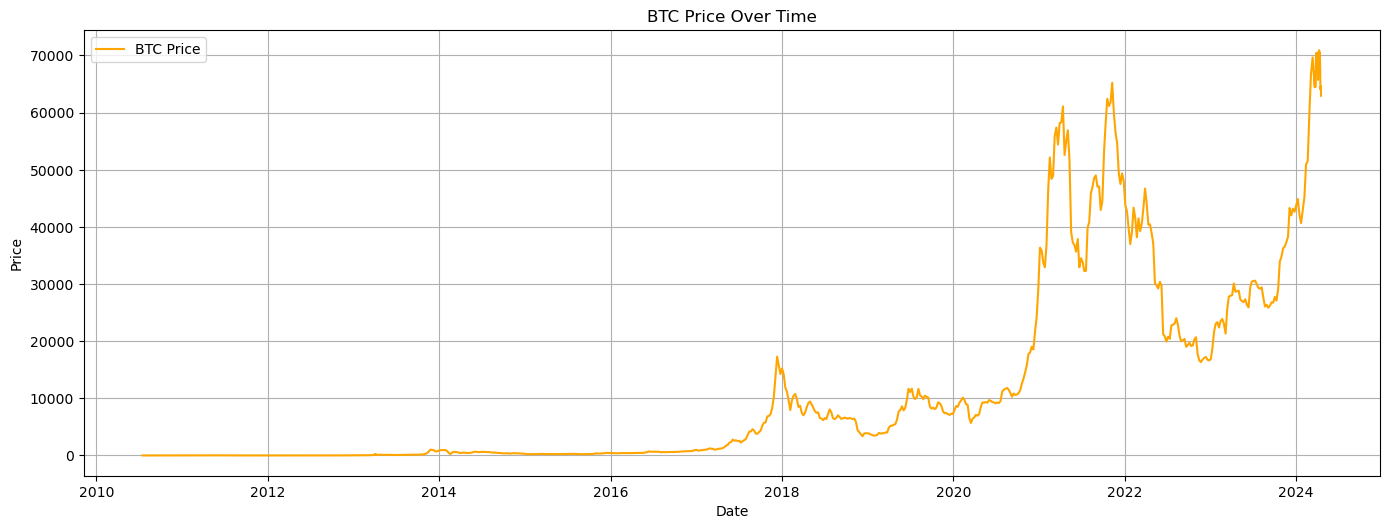

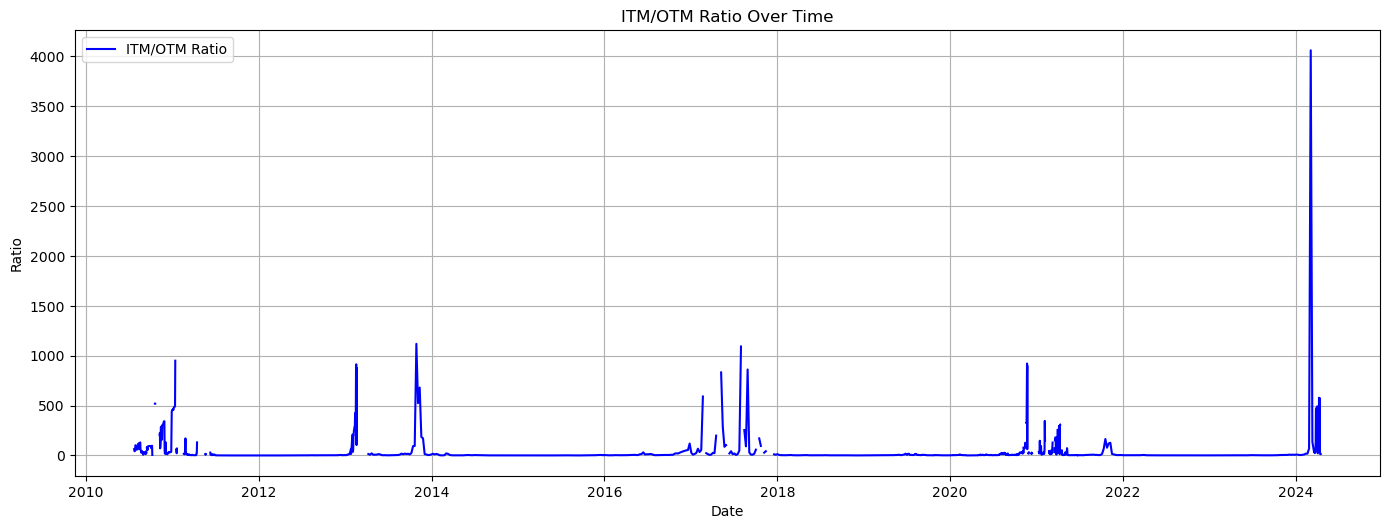

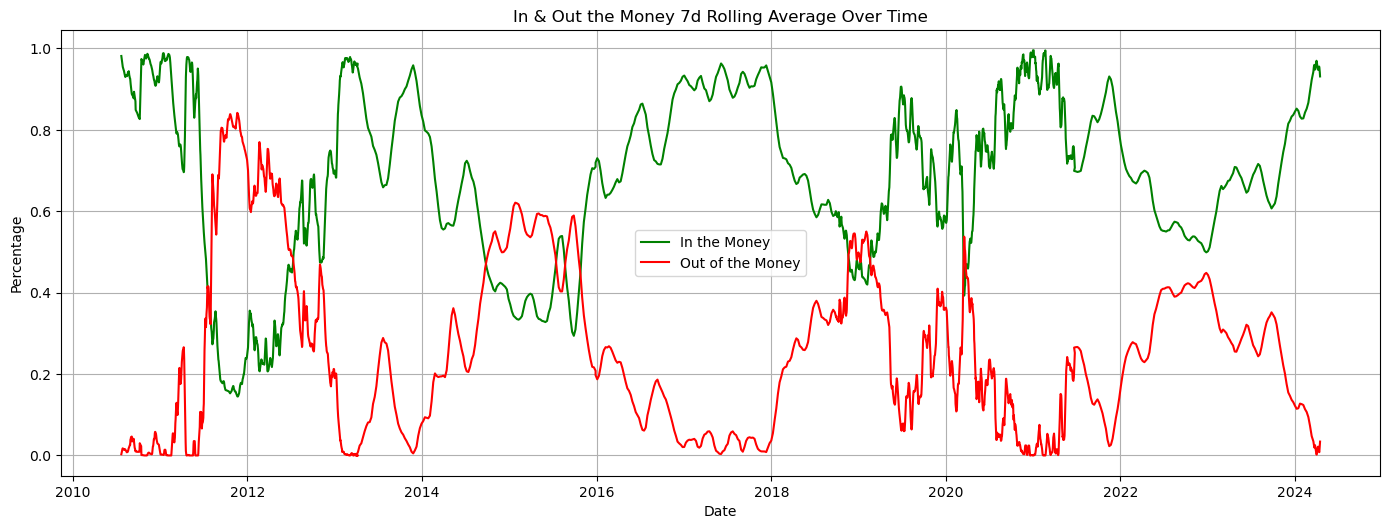

,itm_otm_ratio
DateTime,
2010-07-23 00:00:00+00:00,63.540037
2010-07-24 00:00:00+00:00,51.427272
2010-07-25 00:00:00+00:00,42.682757
2010-07-26 00:00:00+00:00,42.946085
2010-07-27 00:00:00+00:00,53.542464
...,...
2024-04-11 00:00:00+00:00,575.753763
2024-04-12 00:00:00+00:00,33.825904
2024-04-13 00:00:00+00:00,13.633588


In [4915]:
# ITM/OTM DATA

#CLEAN THE DATA
btc_itm_otm.index = pd.to_datetime(btc_itm_otm.index)
btc_itm_otm.drop(columns=['Price', 'At'], inplace=True)
btc_itm_otm.rename(columns={'In': 'itm', 'Out': 'otm'}, inplace=True)

#ROLLING STATISTICS
btc_itm_otm['itm_rolling_avg_7d'] = btc_itm_otm['itm'].rolling(window=7).mean()
btc_itm_otm['otm_rolling_avg_7d'] = btc_itm_otm['otm'].rolling(window=7).mean()

#ITM/OTM RATIO
btc_itm_otm['itm_otm_ratio'] = btc_itm_otm['itm'] / btc_itm_otm['otm']

#DISPLAY DATAFRAME
btc_itm_otm.dropna(inplace=True)
# display(btc_itm_otm)

# VISUALIZE THE DATA
btc_price_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(btc_price.index, 
         btc_price['Price'], 
         label='BTC Price', 
         color='orange')
plt.title('BTC Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

itm_otm_ratio_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(btc_itm_otm.index, 
         btc_itm_otm['itm_otm_ratio'], 
         label='ITM/OTM Ratio', 
         color='blue')
plt.title('ITM/OTM Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

itm_otm_rolling_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(btc_itm_otm.index, 
         btc_itm_otm['itm_rolling_avg_7d'], 
         label='In the Money', 
         color='green')
plt.plot(btc_itm_otm.index,
            btc_itm_otm['otm_rolling_avg_7d'], 
            label='Out of the Money', 
            color='red')
plt.title('In & Out the Money 7d Rolling Average Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

itm_otm_ratio = pd.DataFrame(btc_itm_otm['itm_otm_ratio'])
display(itm_otm_ratio)

#APPEND FEATURES
dataframes.append(itm_otm_ratio)
feature_plots['itm_otm_ratio'] = itm_otm_ratio_plot

,mvrv_ratio,mvrv_7d_mean,mvrv_30d_std
DateTime,,,
2013-04-22 00:00:00+00:00,0.421517,NaN,NaN
2013-04-29 00:00:00+00:00,2.510000,NaN,NaN
2013-05-06 00:00:00+00:00,2.440000,NaN,NaN
2013-05-13 00:00:00+00:00,2.500000,NaN,NaN
2013-05-20 00:00:00+00:00,2.620000,NaN,NaN
...,...,...,...
2024-04-11 00:00:00+00:00,2.470000,2.440000,0.294189
2024-04-12 00:00:00+00:00,2.450000,2.444286,0.286233
2024-04-13 00:00:00+00:00,2.350000,2.438571,0.274801


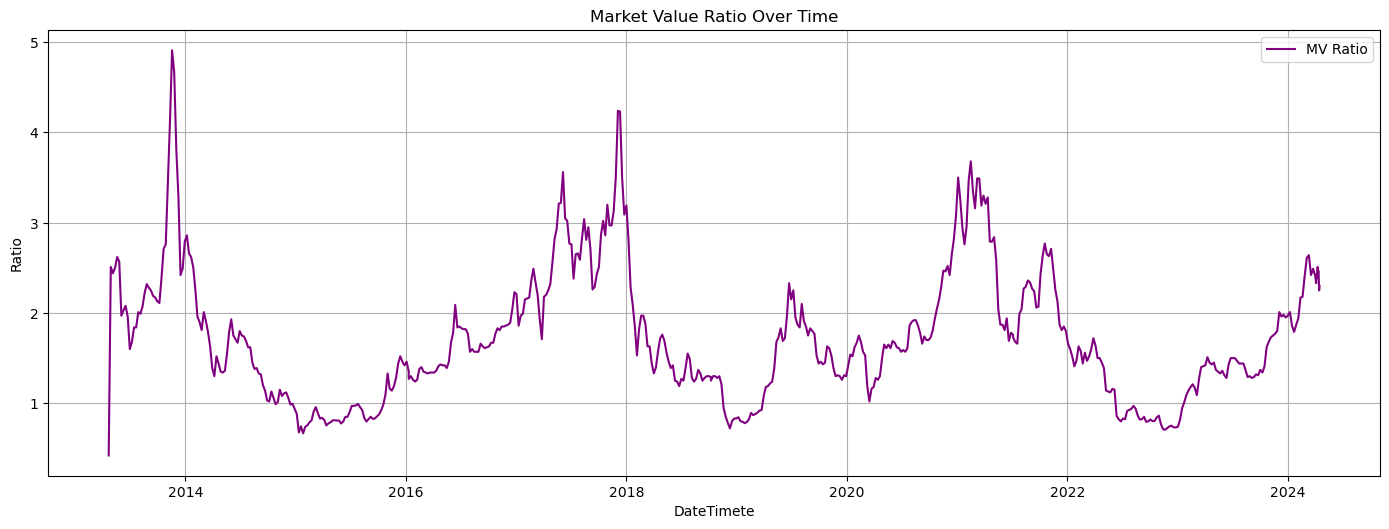

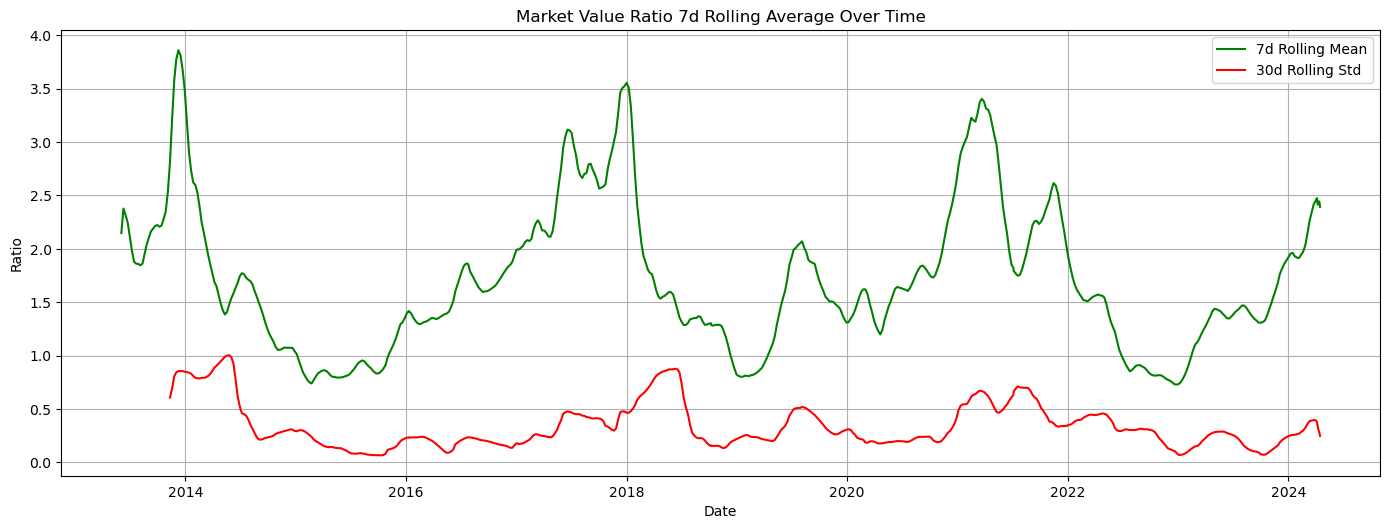

In [4916]:
#MVRV RATIO DATA

#CLEAN DATA
btc_mvrv_ratio.index = pd.to_datetime(btc_mvrv_ratio.index)
btc_mvrv_ratio.drop(columns=['Price'], inplace=True)
btc_mvrv_ratio.rename(columns={'MV Ratio': 'mvrv_ratio'}, inplace=True)

#ROLLING STATISTICS
btc_mvrv_ratio['mvrv_7d_mean'] = btc_mvrv_ratio['mvrv_ratio'].rolling(window=7).mean()
btc_mvrv_ratio['mvrv_30d_std'] = btc_mvrv_ratio['mvrv_ratio'].rolling(window=30).std()

#DISPLAY DATAFRAME
mvrv_rolling_ratio = btc_mvrv_ratio
display(mvrv_rolling_ratio)

# VISUALIZE THE DATA
mvrv_ratio_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(mvrv_rolling_ratio.index, 
         mvrv_rolling_ratio['mvrv_ratio'], 
         label='MV Ratio', 
         color='purple')
plt.title('Market Value Ratio Over Time')
plt.xlabel('DateTimete')
plt.ylabel('Ratio')
plt.legend()  
plt.grid(True)
plt.tight_layout()
plt.show()

mvrv_rolling_ratio_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(mvrv_rolling_ratio.index, 
         mvrv_rolling_ratio['mvrv_7d_mean'], 
         label='7d Rolling Mean', 
         color='green')
plt.plot(mvrv_rolling_ratio.index,
            mvrv_rolling_ratio['mvrv_30d_std'], 
            label='30d Rolling Std', 
            color='red')
plt.title('Market Value Ratio 7d Rolling Average Over Time')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND FEATURES
dataframes.append(mvrv_rolling_ratio)
feature_plots['mvrv_rolling_ratio_plot'] = mvrv_rolling_ratio_plot

,btc_close
DateTime,
2010-07-17 00:00:00+00:00,0.049510
2010-07-18 00:00:00+00:00,0.072630
2010-07-19 00:00:00+00:00,0.085150
2010-07-20 00:00:00+00:00,0.078035
2010-07-21 00:00:00+00:00,0.072775
...,...
2024-04-12 00:00:00+00:00,68252.130000
2024-04-13 00:00:00+00:00,64751.035000
2024-04-14 00:00:00+00:00,64052.340000


,eth_close
DateTime,
2015-08-07 00:00:00+00:00,1.837350
2015-08-08 00:00:00+00:00,1.575000
2015-08-09 00:00:00+00:00,1.200000
2015-08-10 00:00:00+00:00,1.200000
2015-08-11 00:00:00+00:00,0.925200
...,...
2024-04-12 00:00:00+00:00,3324.200000
2024-04-13 00:00:00+00:00,3067.115000
2024-04-14 00:00:00+00:00,3043.735000


,doge_close
DateTime,
2014-02-01 00:00:00+00:00,0.001035
2014-02-02 00:00:00+00:00,0.001893
2014-02-03 00:00:00+00:00,0.023664
2014-02-04 00:00:00+00:00,0.023400
2014-02-05 00:00:00+00:00,0.011983
...,...
2024-04-12 00:00:00+00:00,0.181050
2024-04-13 00:00:00+00:00,0.153000
2024-04-14 00:00:00+00:00,0.154700


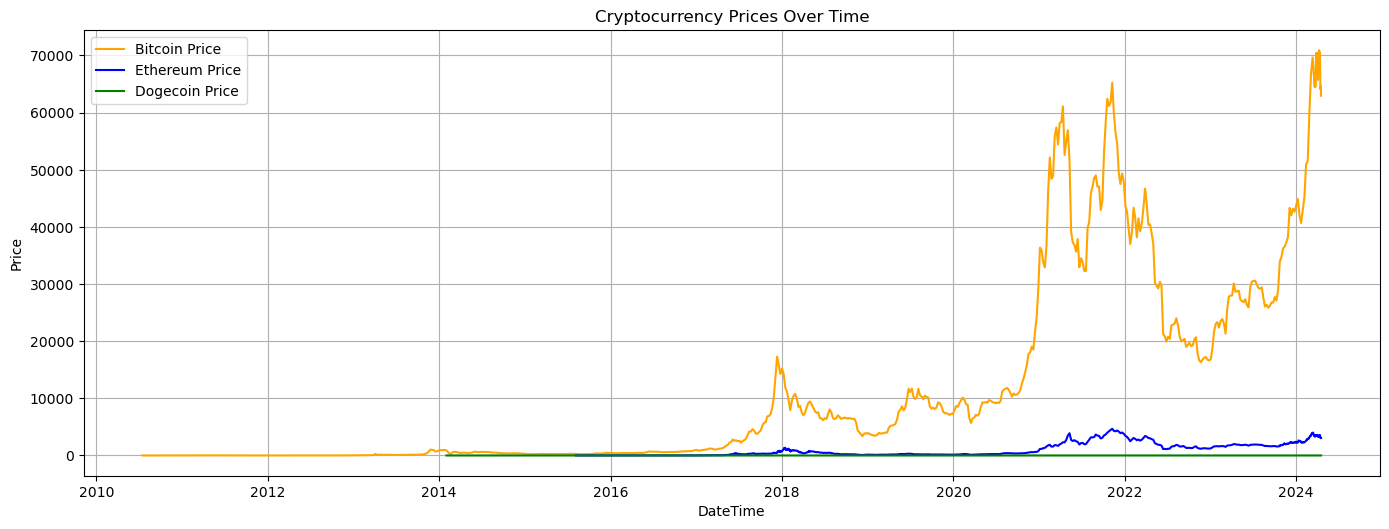

In [4917]:
# CRYPTO PRICE DATA

#CLEAN DATA
btc_price.rename(columns={'Price': 'btc_close'}, inplace=True)
eth_price.rename(columns={'Price': 'eth_close'}, inplace=True)
doge_price.rename(columns={'Price': 'doge_close'}, inplace=True)
btc_close = btc_price
eth_close = eth_price
doge_close = doge_price
display(btc_close)
display(eth_close)
display(doge_close)

# VISUALIZE THE DATA
crypto_prices_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(btc_close.index, 
         btc_close['btc_close'], 
         label='Bitcoin Price', 
         color='orange')
plt.plot(eth_close.index, 
         eth_close['eth_close'], 
         label='Ethereum Price', 
         color='blue')
plt.plot(doge_close.index, 
         doge_close['doge_close'], 
         label='Dogecoin Price', 
         color='green')
plt.title('Cryptocurrency Prices Over Time')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND FEATURES
dataframes.append(btc_close)
dataframes.append(eth_close)
dataframes.append(doge_close)
feature_plots['crypto_prices'] = crypto_prices_plot

### Mining Data

,hash_rate,hash_rate_7d_mean
DateTime,,
2009-01-15 00:00:00+00:00,6.000000e-06,5.857143e-06
2009-01-16 00:00:00+00:00,5.000000e-06,5.285714e-06
2009-01-17 00:00:00+00:00,5.000000e-06,5.428571e-06
2009-01-18 00:00:00+00:00,5.000000e-06,5.428571e-06
2009-01-19 00:00:00+00:00,6.000000e-06,5.571429e-06
...,...,...
2024-04-11 00:00:00+00:00,5.728092e+08,6.344379e+08
2024-04-12 00:00:00+00:00,5.864980e+08,6.277089e+08
2024-04-13 00:00:00+00:00,7.099043e+08,6.368902e+08


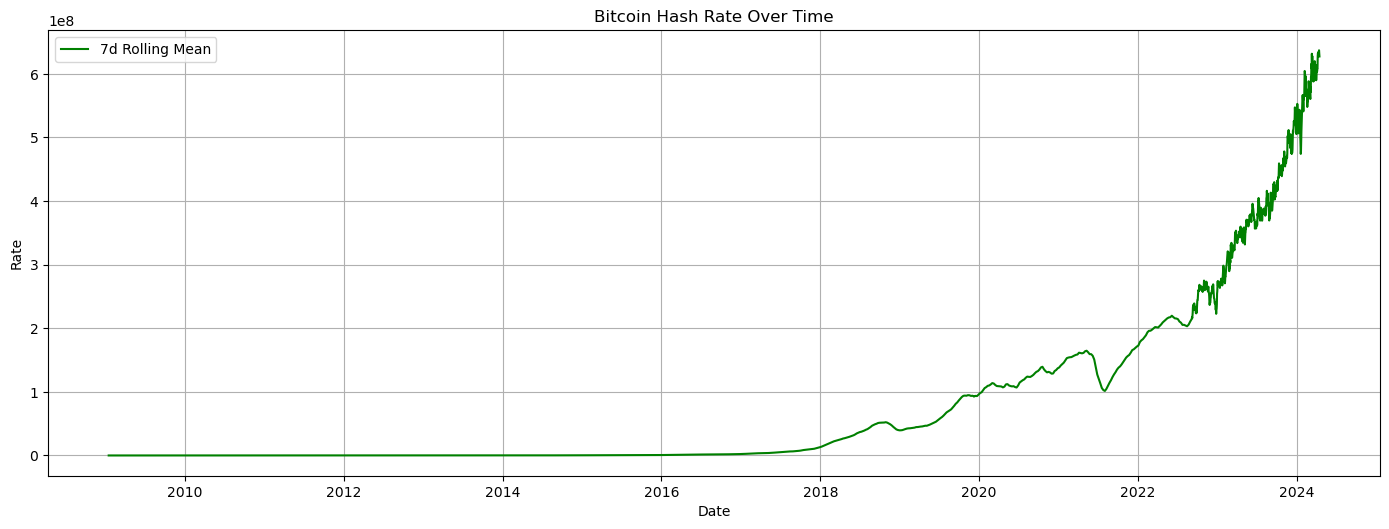

In [4918]:
# MINER HASH RATE

#DIPLAY DATAFRAME
btc_miner_hash_rate.rename(columns={'Hash Rate': 'hash_rate'}, inplace=True)
btc_miner_hash_rate.drop(columns=['Average Size In Bytes', 'Price', 'Average Difficulty'] , inplace=True)

#ROLLING STATISTICS
btc_miner_hash_rate['hash_rate_7d_mean'] = btc_miner_hash_rate['hash_rate'].rolling(window=7).mean()
btc_miner_hash_rate.dropna(inplace=True)
miner_rolling_hash_rate = btc_miner_hash_rate
display(miner_rolling_hash_rate)

# VISUALIZE THE DATA
miner_rolling_hash_rate_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(miner_rolling_hash_rate.index,
            miner_rolling_hash_rate['hash_rate_7d_mean'], 
            label='7d Rolling Mean', 
            color='green')
plt.title('Bitcoin Hash Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND FEATURES 
dataframes.append(miner_rolling_hash_rate)
feature_plots['miner_rolling_hash_rate'] = miner_rolling_hash_rate_plot

,agg_miner_netflows
DateTime,
2009-01-03 00:00:00+00:00,50.000000
2009-01-09 00:00:00+00:00,700.000000
2009-01-10 00:00:00+00:00,3050.000000
2009-01-11 00:00:00+00:00,4650.000000
2009-01-12 00:00:00+00:00,4689.000000
...,...
2024-04-11 00:00:00+00:00,2732.497377
2024-04-12 00:00:00+00:00,-1427.096925
2024-04-13 00:00:00+00:00,-1979.958773


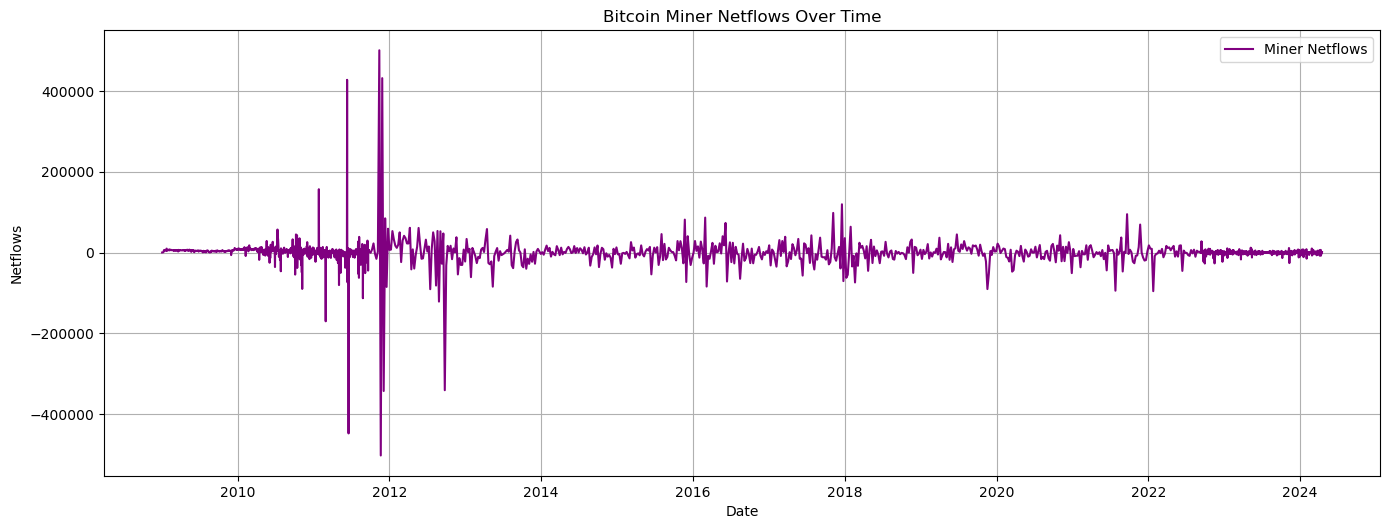

In [4919]:
# MINER NETFLOWS 

#DIPLAY DATAFRAME
btc_miner_netflows.drop(columns=['Poolin', 'Viabtc', 'Antpool', '1thash&58coin', 'Binance', 'Bitclub Network' ,'Bitfury', 'Bixin', 'Btc.Top', 'Btcc Pool', 'Btccom', 'Bw.Com', 'F2pool', 'Foundryusapool', 'Huobi.Pool', 'Slushpool', 'Others', 'Unknown'], inplace=True)
btc_miner_netflows.rename(columns={'All Miners': 'agg_miner_netflows'}, inplace=True)
btc_miner_netflows.dropna(inplace=True)
miner_netflows = btc_miner_netflows
display(miner_netflows)

# VISUALIZE THE DATA
miner_netflows_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(miner_netflows.index, 
         miner_netflows['agg_miner_netflows'], 
         label='Miner Netflows', 
         color='purple')
plt.title('Bitcoin Miner Netflows Over Time')
plt.xlabel('Date')
plt.ylabel('Netflows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(miner_netflows)
feature_plots['miner_netflows'] = miner_netflows_plot

,agg_miner_reserves
DateTime,
2009-01-03 00:00:00+00:00,5.000000e+01
2009-01-04 00:00:00+00:00,5.000000e+01
2009-01-05 00:00:00+00:00,5.000000e+01
2009-01-06 00:00:00+00:00,5.000000e+01
2009-01-07 00:00:00+00:00,5.000000e+01
...,...
2024-04-10 00:00:00+00:00,1.921566e+06
2024-04-11 00:00:00+00:00,1.924275e+06
2024-04-12 00:00:00+00:00,1.922830e+06


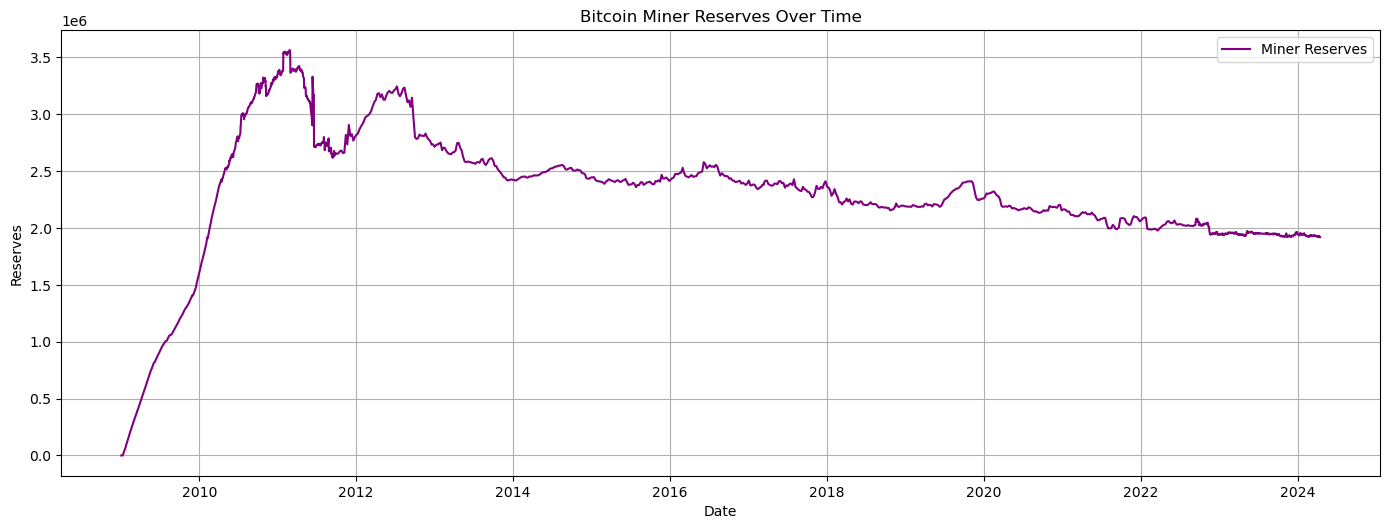

In [4920]:
# MINER RESERVES 

#DIPLAY DATAFRAME
btc_miner_reserves.drop(columns=['Poolin', 'Viabtc', 'Antpool', '1thash&58coin', 'Binance', 'Bitclub Network' ,'Bitfury', 'Bixin', 'Btc.Top', 'Btcc Pool', 'Btccom', 'Bw.Com', 'F2pool', 'Foundryusapool', 'Huobi.Pool', 'Slushpool', 'Others', 'Unknown'], inplace=True)
btc_miner_reserves.rename(columns={'All Miners': 'agg_miner_reserves'}, inplace=True)
btc_miner_reserves.dropna(inplace=True)
miner_reserves = btc_miner_reserves
display(miner_reserves)

# VISUALIZE THE DATA
miner_reserves_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(miner_reserves.index, 
         miner_reserves['agg_miner_reserves'], 
         label='Miner Reserves', 
         color='purple')
plt.title('Bitcoin Miner Reserves Over Time')
plt.xlabel('Date')
plt.ylabel('Reserves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(miner_reserves)
feature_plots['miner_reserves'] = miner_reserves_plot

,difficulty
DateTime,
2009-01-03,1.000000e+00
2009-01-09,1.000000e+00
2009-01-10,1.000000e+00
2009-01-11,1.000000e+00
2009-01-12,1.000000e+00
...,...
2024-03-30,8.312700e+13
2024-03-31,8.312700e+13
2024-04-01,8.312700e+13


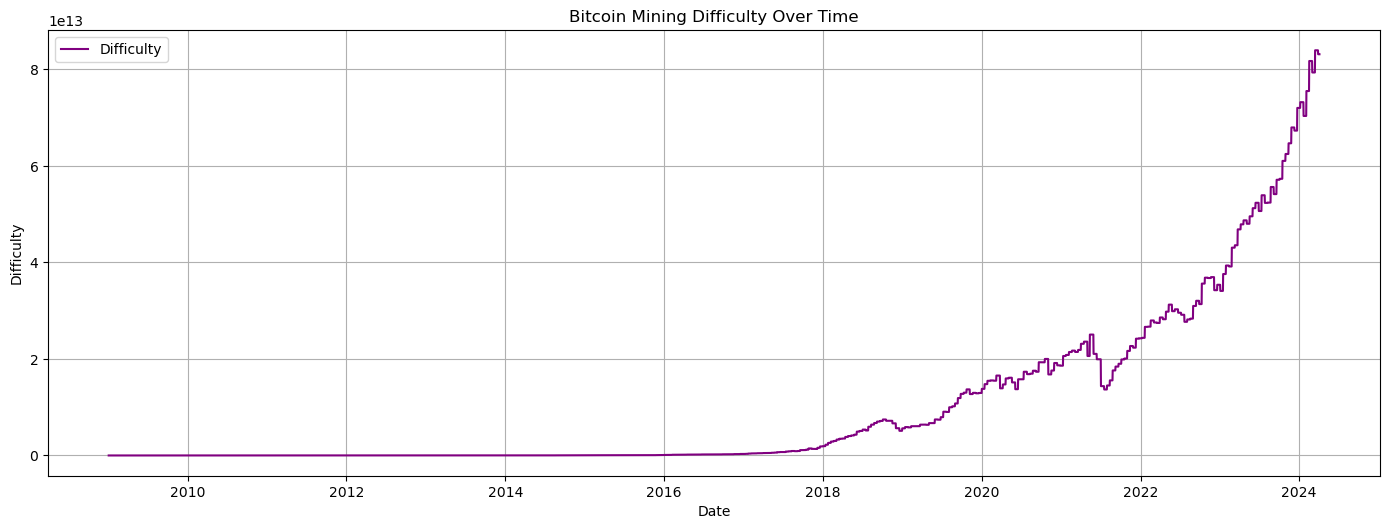

In [4921]:
# MINER DIFFICULTY 

#DIPLAY DATAFRAME
btc_miner_difficulty.rename(columns={'Difficulty': 'difficulty'}, inplace=True)
btc_miner_difficulty.dropna(inplace=True)
miner_difficulty = btc_miner_difficulty
display(miner_difficulty)

# VISUALIZE THE DATA
miner_difficulty_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(miner_difficulty.index, 
         miner_difficulty['difficulty'], 
         label='Difficulty', 
         color='purple')
plt.title('Bitcoin Mining Difficulty Over Time')
plt.xlabel('Date')
plt.ylabel('Difficulty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(miner_difficulty)
feature_plots['miner_difficulty'] = miner_difficulty_plot

### Network Data

,activity_fee_ratio
DateTime,
2009-02-03 00:00:00+00:00,0.013052
2009-05-02 00:00:00+00:00,0.000211
2009-05-11 00:00:00+00:00,0.000813
2009-07-20 00:00:00+00:00,0.000729
2009-08-07 00:00:00+00:00,0.000677
...,...
2024-04-11 00:00:00+00:00,0.000139
2024-04-12 00:00:00+00:00,0.000189
2024-04-13 00:00:00+00:00,0.000122


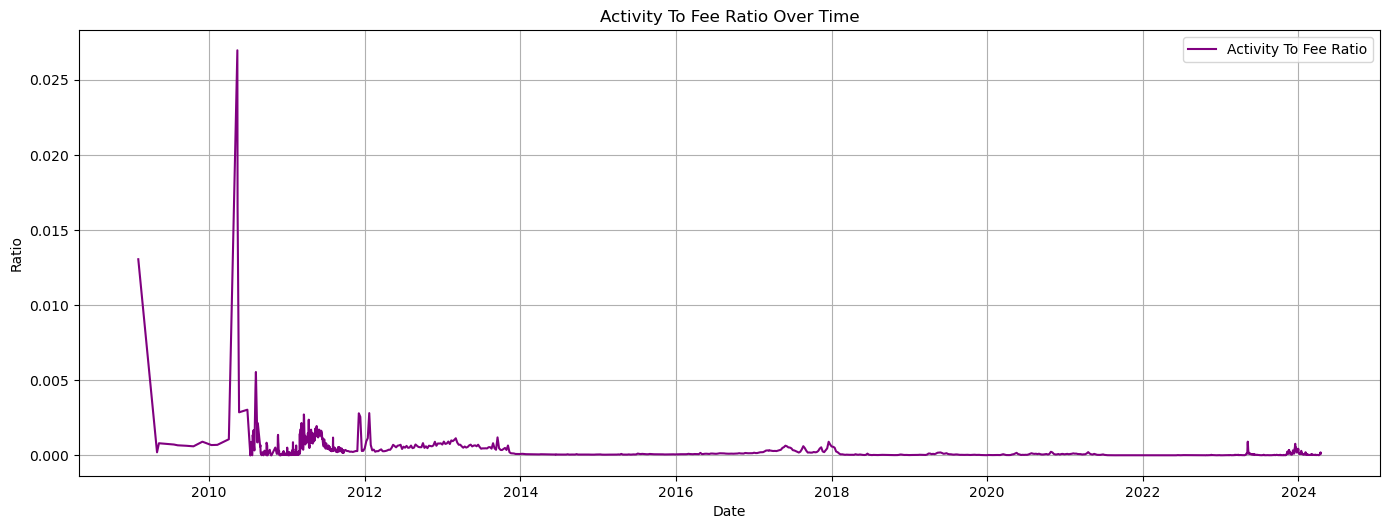

In [4922]:
#ACTIVITY TO FEE RATIO

#DIPLAY DATAFRAME
btc_activity_fee_ratio.drop(columns=['Price'], inplace=True)
btc_activity_fee_ratio.rename(columns={'Activity To Fee Ratio': 'activity_fee_ratio'}, inplace=True)
btc_activity_fee_ratio.dropna(inplace=True)
activity_fee_ratio = btc_activity_fee_ratio
display(activity_fee_ratio)

# VISUALIZE THE DATA
activity_fee_ratio_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(
    activity_fee_ratio.index, 
    activity_fee_ratio['activity_fee_ratio'], 
    label='Activity To Fee Ratio', 
    color='purple')
plt.title('Activity To Fee Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#APPEND TO FEATURES LIST
dataframes.append(activity_fee_ratio)
feature_plots['activity_fee_ratio'] = activity_fee_ratio_plot

,daily_active_addresses,daily_active_addresses_7d_mean
DateTime,,
2009-01-15 00:00:00+00:00,140.0,95.142857
2009-01-16 00:00:00+00:00,114.0,109.428571
2009-01-17 00:00:00+00:00,109.0,116.285714
2009-01-18 00:00:00+00:00,111.0,118.857143
2009-01-19 00:00:00+00:00,133.0,123.285714
...,...,...
2024-04-11 00:00:00+00:00,749867.0,874614.571429
2024-04-12 00:00:00+00:00,831521.0,856389.142857
2024-04-13 00:00:00+00:00,866882.0,848748.142857


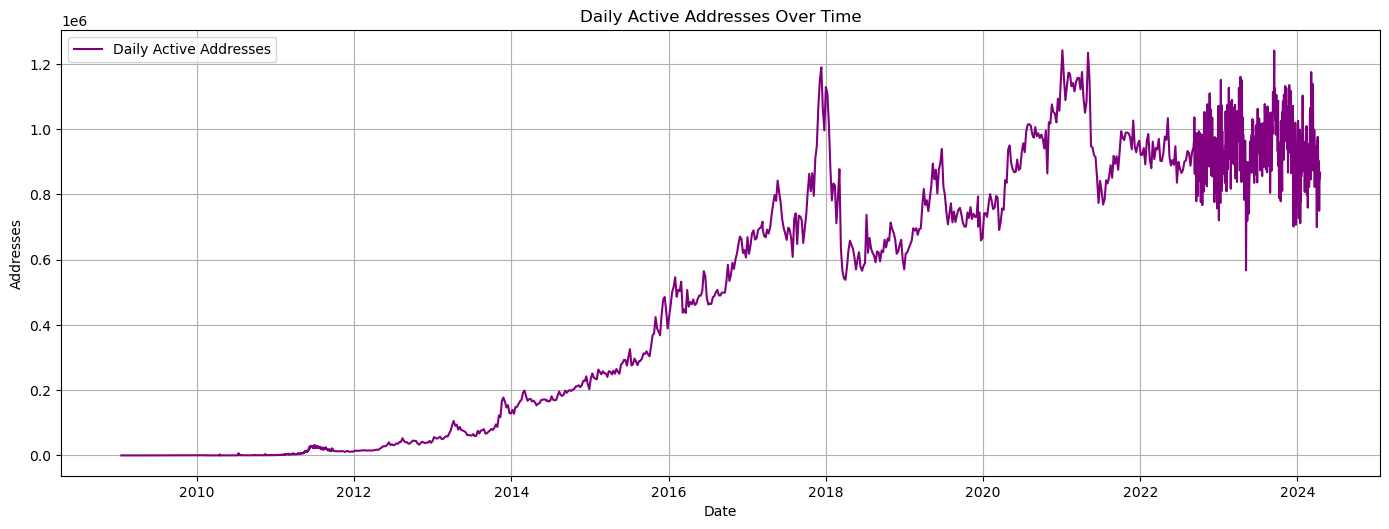

In [4923]:
# DAILY ACTIVE ADDRESSES

#DIPLAY DATAFRAME
btc_daily_active_addresses.drop(columns=['Price', 'Zero Balance Addresses', 'New Addresses'], inplace=True)
btc_daily_active_addresses.rename(columns={'Active Addresses': 'daily_active_addresses'}, inplace=True)

#ROLLING STATISTICS
btc_daily_active_addresses['daily_active_addresses_7d_mean'] = btc_daily_active_addresses['daily_active_addresses'].rolling(window=7).mean()
btc_daily_active_addresses.dropna(inplace=True)
daily_active_addresses = btc_daily_active_addresses
display(daily_active_addresses)

# VISUALIZE THE DATA
daily_active_addresses_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(
    daily_active_addresses.index, 
    daily_active_addresses['daily_active_addresses'], 
    label='Daily Active Addresses', 
    color='purple')
plt.title('Daily Active Addresses Over Time')
plt.xlabel('Date')
plt.ylabel('Addresses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(daily_active_addresses)
feature_plots['daily_active_addresses'] = daily_active_addresses_plot

,new_adoption_rate
DateTime,
2009-01-03 00:00:00+00:00,1.000000
2009-01-09 00:00:00+00:00,1.000000
2009-01-10 00:00:00+00:00,1.000000
2009-01-11 00:00:00+00:00,1.000000
2009-01-12 00:00:00+00:00,0.990196
...,...
2024-04-11 00:00:00+00:00,0.469831
2024-04-12 00:00:00+00:00,0.463511
2024-04-13 00:00:00+00:00,0.448077


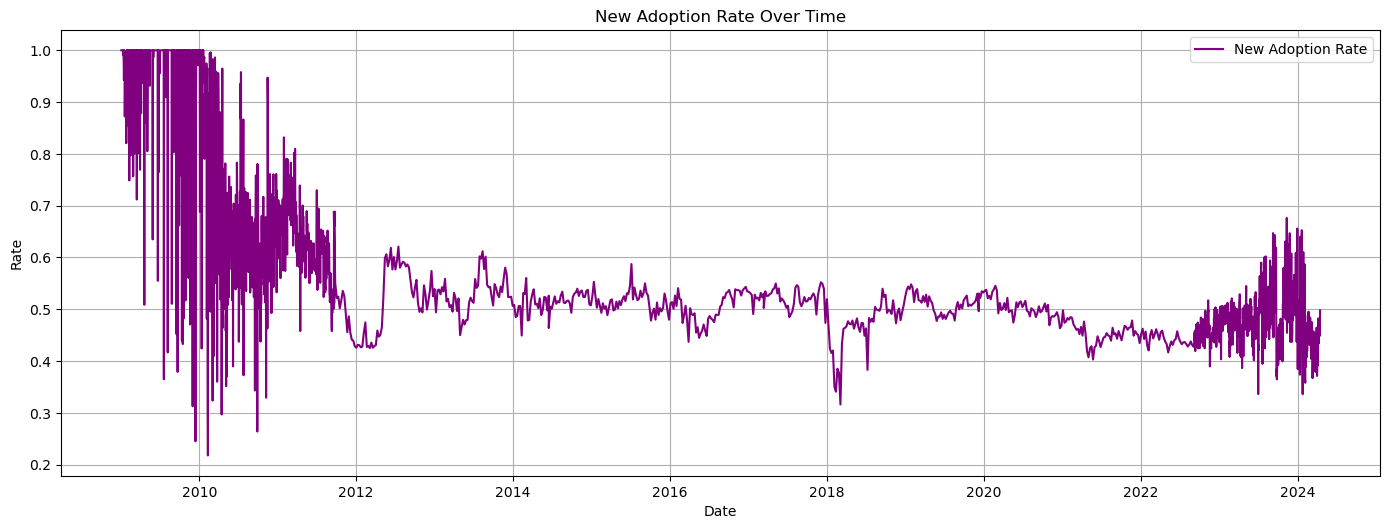

In [4924]:
# NEW ADOPTION RATE

#DIPLAY DATAFRAME
btc_new_adoption_rate.drop(columns=['Price'], inplace=True)
btc_new_adoption_rate.rename(columns={'New Adoption Rate': 'new_adoption_rate'}, inplace=True)
btc_new_adoption_rate.dropna(inplace=True)
new_adoption_rate = btc_new_adoption_rate
display(new_adoption_rate)

# VISUALIZE THE DATA
new_adoption_rate_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(
    new_adoption_rate.index, 
    new_adoption_rate['new_adoption_rate'], 
    label='New Adoption Rate', 
    color='purple')
plt.title('New Adoption Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(new_adoption_rate)
feature_plots['new_adoption_rate'] = new_adoption_rate_plot

,total_addresses
DateTime,
2009-01-03 00:00:00+00:00,1.000000e+00
2009-01-04 00:00:00+00:00,1.000000e+00
2009-01-05 00:00:00+00:00,1.000000e+00
2009-01-06 00:00:00+00:00,1.000000e+00
2009-01-07 00:00:00+00:00,1.000000e+00
...,...
2024-04-11 00:00:00+00:00,1.301921e+09
2024-04-12 00:00:00+00:00,1.302306e+09
2024-04-13 00:00:00+00:00,1.302695e+09


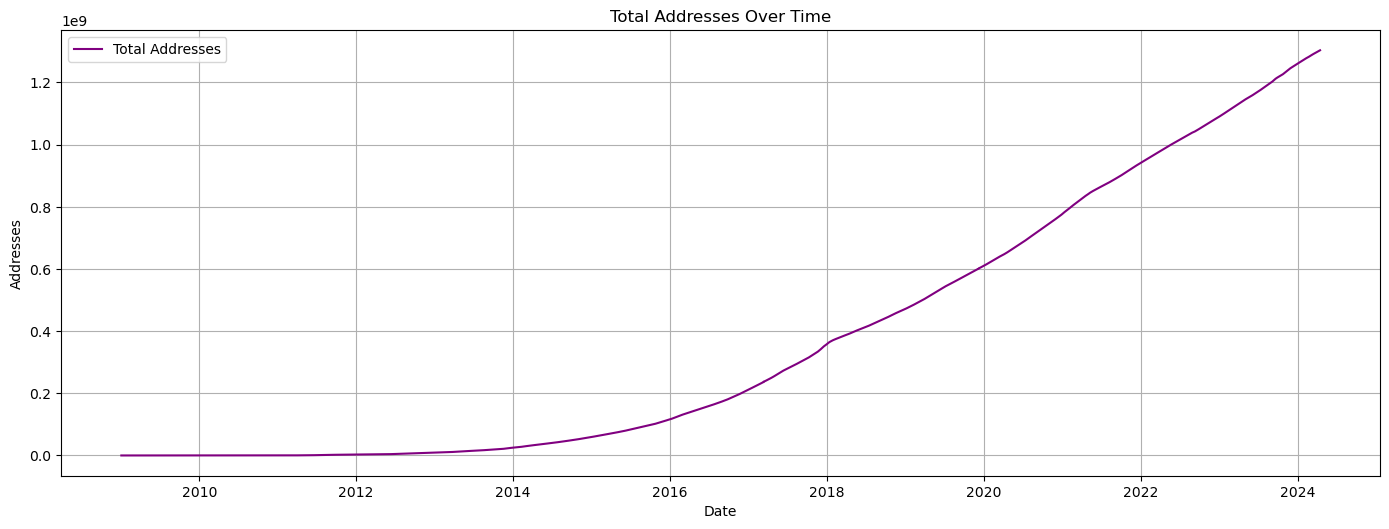

In [4925]:
# TOTAL ADDRESSES

#DIPLAY DATAFRAME
btc_total_addresses.drop(columns=['Price', 'Total Zero Balance', 'Total With Balance'], inplace=True)
btc_total_addresses.rename(columns={'Total': 'total_addresses'}, inplace=True)
btc_total_addresses.dropna(inplace=True)
total_addresses = btc_total_addresses
display(total_addresses)

# VISUALIZE THE DATA
total_addresses_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(total_addresses.index, 
         total_addresses['total_addresses'], 
         label='Total Addresses', 
         color='purple')
plt.title('Total Addresses Over Time')
plt.xlabel('Date')
plt.ylabel('Addresses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(total_addresses)
feature_plots['total_addresses'] = total_addresses_plot

,total_fees
DateTime,
2009-02-03 00:00:00+00:00,2.01
2009-05-02 00:00:00+00:00,0.03
2009-05-11 00:00:00+00:00,0.10
2009-07-20 00:00:00+00:00,0.14
2009-08-07 00:00:00+00:00,0.13
...,...
2024-04-11 00:00:00+00:00,104.38
2024-04-12 00:00:00+00:00,157.22
2024-04-13 00:00:00+00:00,105.50


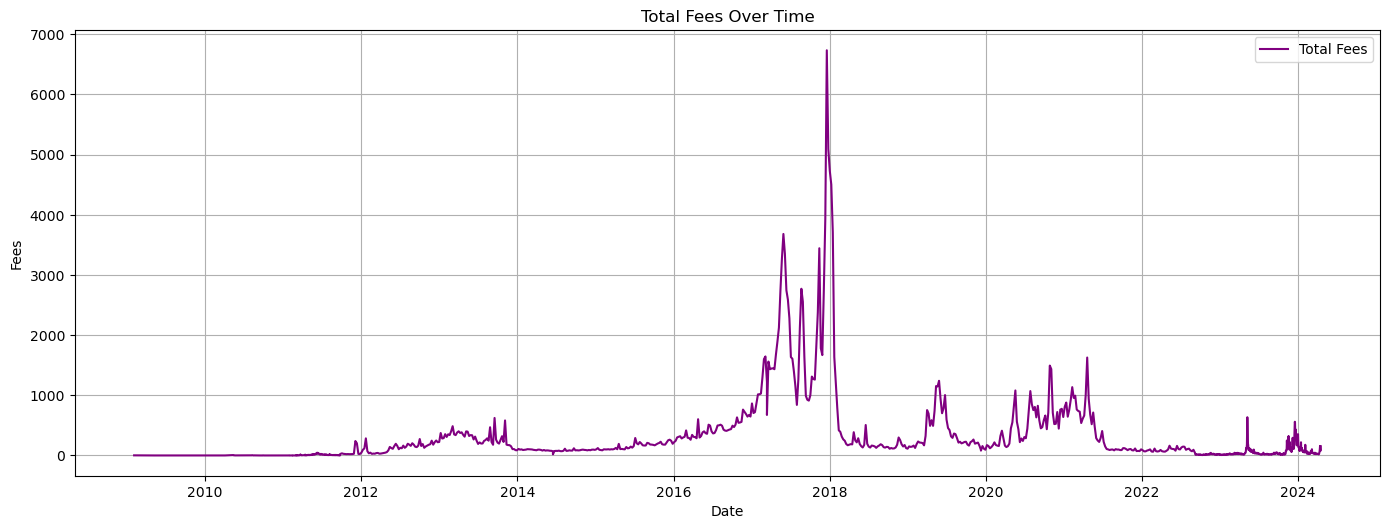

In [4926]:
# TOTAL FEES 

#DIPLAY DATAFRAME
btc_total_fees.rename(columns={'Total Fees': 'total_fees'}, inplace=True)
btc_total_fees.dropna(inplace=True)
total_fees = btc_total_fees
display(total_fees)

# VISUALIZE THE DATA
total_fees_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(total_fees.index, 
         total_fees['total_fees'], 
         label='Total Fees', 
         color='purple')
plt.title('Total Fees Over Time')
plt.xlabel('Date')
plt.ylabel('Fees')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(total_fees)
feature_plots['total_fees'] = total_fees_plot

,total_transactions
DateTime,
2009-01-03 00:00:00+00:00,1.0
2009-01-09 00:00:00+00:00,14.0
2009-01-10 00:00:00+00:00,61.0
2009-01-11 00:00:00+00:00,93.0
2009-01-12 00:00:00+00:00,101.0
...,...
2024-04-11 00:00:00+00:00,476241.0
2024-04-12 00:00:00+00:00,448489.0
2024-04-13 00:00:00+00:00,507173.0


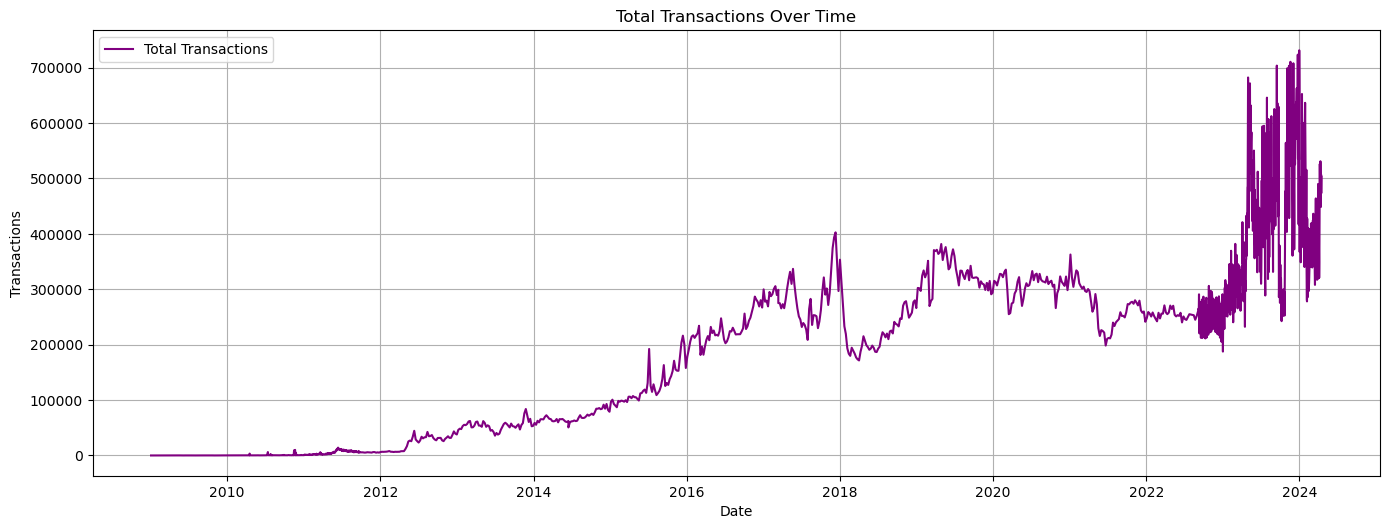

In [4927]:
# TOTAL TRANSACTIONS

#DIPLAY DATAFRAME
btc_toal_transactions.drop(columns=['Price'], inplace=True)
btc_toal_transactions.rename(columns={'Number Of Transactions': 'total_transactions'}, inplace=True)
btc_toal_transactions.dropna(inplace=True)
total_transactions = btc_toal_transactions
display(total_transactions)

# VISUALIZE THE DATA
total_transactions_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(total_transactions.index, 
         total_transactions['total_transactions'], 
         label='Total Transactions', 
         color='purple')
plt.title('Total Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(total_transactions)
feature_plots['total_transactions'] = total_transactions_plot

,transaction_volume
DateTime,
2009-01-03 00:00:00+00:00,50.000000
2009-01-09 00:00:00+00:00,700.000000
2009-01-10 00:00:00+00:00,3050.000000
2009-01-11 00:00:00+00:00,4650.000000
2009-01-12 00:00:00+00:00,4879.000000
...,...
2024-04-11 00:00:00+00:00,814237.496766
2024-04-12 00:00:00+00:00,798696.518339
2024-04-13 00:00:00+00:00,639675.430124


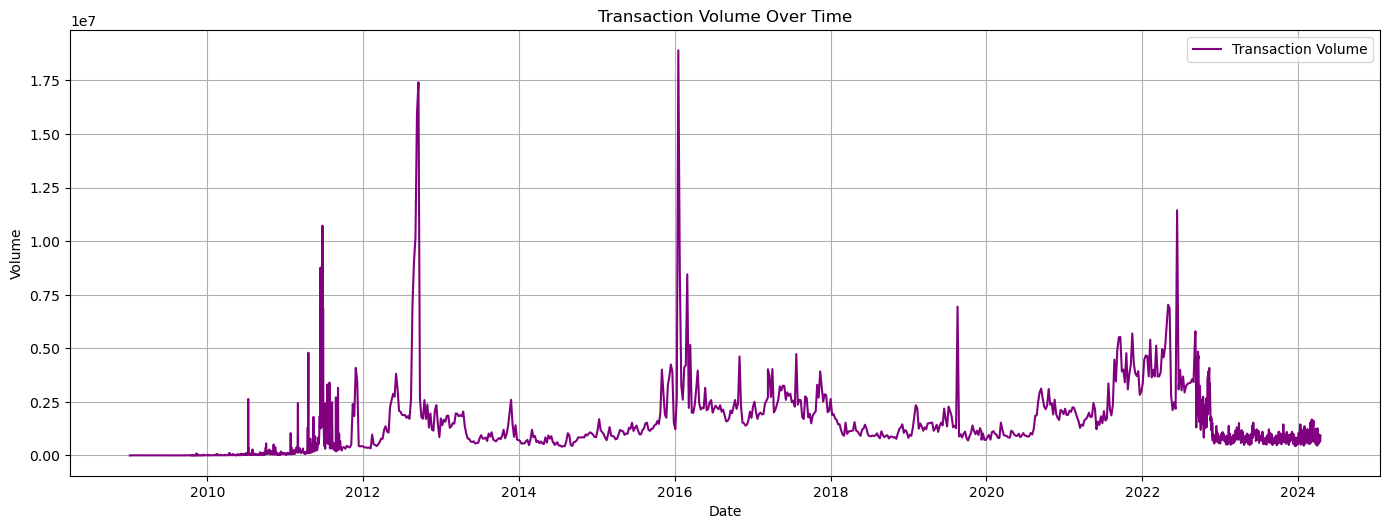

In [4928]:
# TRANSACTION VOLUME

#DIPLAY DATAFRAME
btc_transaction_volume.drop(columns=['Price'], inplace=True)
btc_transaction_volume.rename(columns={'Total Volume': 'transaction_volume'}, inplace=True)
btc_transaction_volume.dropna(inplace=True)
transaction_volume = btc_transaction_volume
display(transaction_volume)

# VISUALIZE THE DATA
transaction_volume_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(transaction_volume.index, 
         transaction_volume['transaction_volume'], 
         label='Transaction Volume', 
         color='purple')
plt.title('Transaction Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(transaction_volume)
feature_plots['transaction_volume'] = transaction_volume_plot

,large_holder_netflows
DateTime,
2008-12-29,50.000000
2009-01-05,8400.000000
2009-01-12,40479.000000
2009-01-19,2725.000000
2009-01-26,2750.000000
...,...
2024-03-18,77904.720000
2024-03-25,3365.650000
2024-04-01,27897.040000


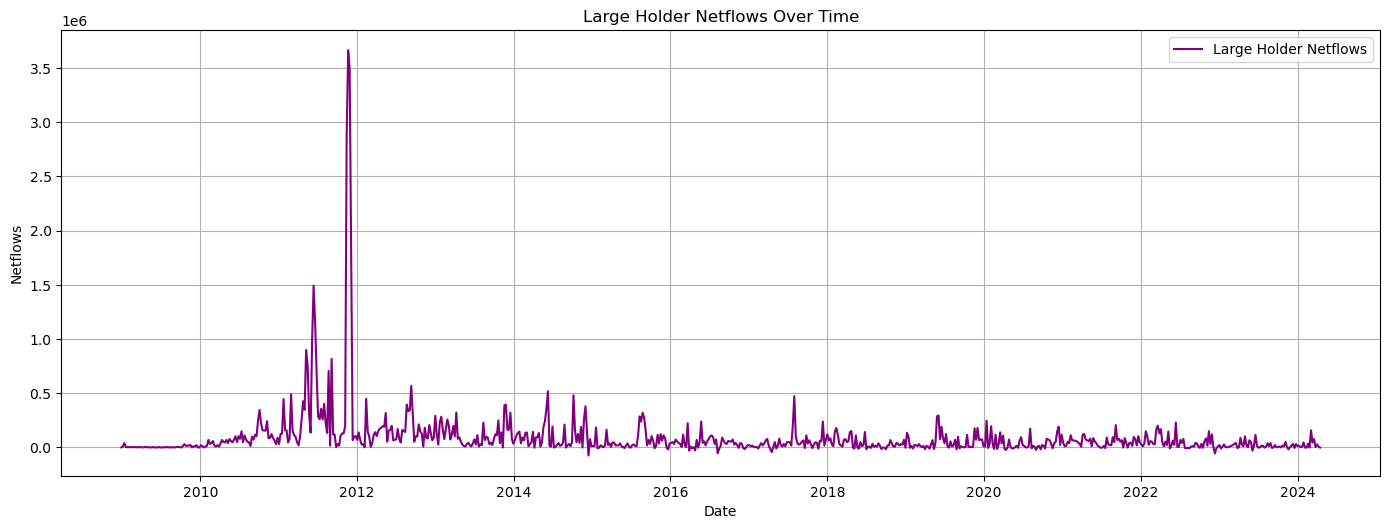

In [4929]:
# LARGE HOLDER NETFLOWS

#DIPLAY DATAFRAME
btc_large_holder_netflows.drop(columns=['Price'], inplace=True)
btc_large_holder_netflows.rename(columns={'Netflow': 'large_holder_netflows'}, inplace=True)
btc_large_holder_netflows.dropna(inplace=True)
large_holder_netflows = btc_large_holder_netflows
display(large_holder_netflows)

# VISUALIZE THE DATA
large_holder_netflows_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(large_holder_netflows.index, 
         large_holder_netflows['large_holder_netflows'], 
         label='Large Holder Netflows', 
         color='purple')
plt.title('Large Holder Netflows Over Time')
plt.xlabel('Date')
plt.ylabel('Netflows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(large_holder_netflows)
feature_plots['large_holder_netflows'] = large_holder_netflows_plot

### Exchange Data

,agg_cex_netflows
DateTime,
2013-04-22 00:00:00+00:00,0.222407
2013-04-29 00:00:00+00:00,1.375288
2013-05-06 00:00:00+00:00,-0.182078
2013-05-13 00:00:00+00:00,4.486613
2013-05-20 00:00:00+00:00,0.470153
...,...
2024-04-12 00:00:00+00:00,-798.536257
2024-04-13 00:00:00+00:00,-386.785712
2024-04-14 00:00:00+00:00,-1102.629301


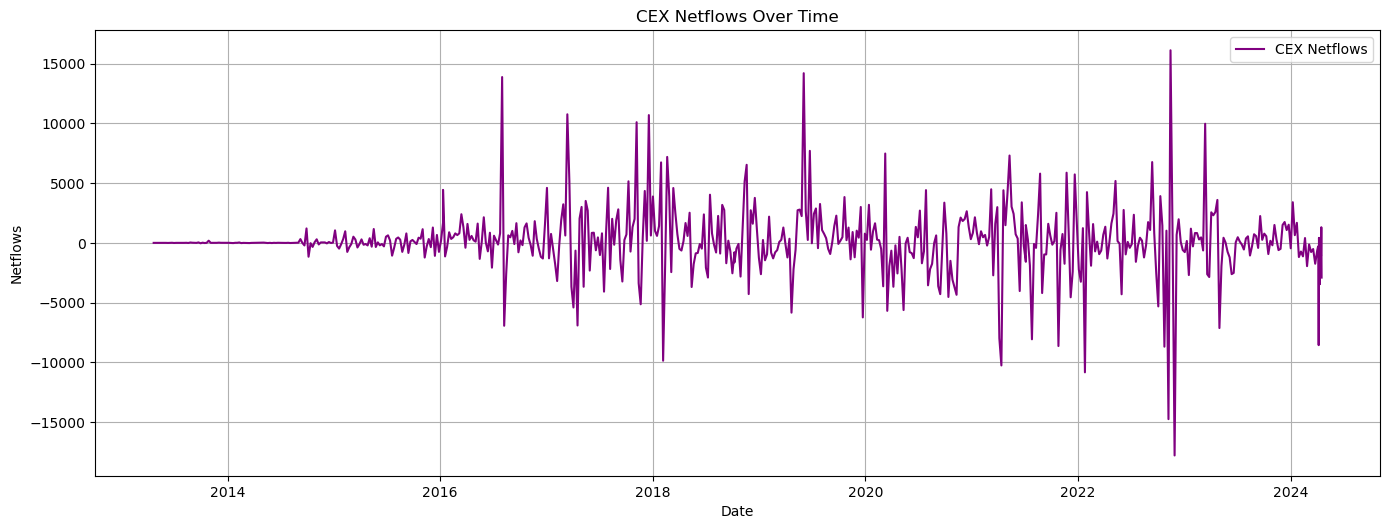

In [4930]:
#CEX NETFLOWS

#DIPLAY DATAFRAME
btc_cex_netflows.drop(columns=['Price', 'Binance', 'Bitfinex', 'Bitstamp', 'Coinbase', 'Gemini', 'Huobi', 'Kraken', 'Luno', 'Okex', 'Poloniex'], inplace=True)
btc_cex_netflows.rename(columns={'Aggregated Exchanges': 'agg_cex_netflows'}, inplace=True)
btc_cex_netflows.dropna(inplace=True)
cex_netflows = btc_cex_netflows
display(cex_netflows)

# VISUALIZE THE DATA
cex_netflows_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(cex_netflows.index, 
         cex_netflows['agg_cex_netflows'], 
         label='CEX Netflows', 
         color='purple')
plt.title('CEX Netflows Over Time')
plt.xlabel('Date')
plt.ylabel('Netflows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(cex_netflows)
feature_plots['cex_netflows'] = cex_netflows_plot

In [4931]:
#CEX INFLOWS

#DIPLAY DATAFRAME
btc_cex_inflows.drop(columns=['Price', 'Binance', 'Bitfinex', 'Bitstamp', 'Coinbase', 'Gemini', 'Huobi', 'Kraken', 'Luno', 'Okex', 'Poloniex'], inplace=True)
btc_cex_inflows.rename(columns={'Aggregated Exchanges': 'agg_cex_inflows'}, inplace=True)
btc_cex_inflows.dropna(inplace=True)
cex_inflows = btc_cex_inflows
display(btc_cex_inflows)

# VISUALIZE THE DATA
cex_inflows_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(cex_inflows.index, 
         cex_inflows['agg_cex_inflows'], 
         label='CEX Inflows', 
         color='purple')
plt.title('CEX Inflows Over Time')
plt.xlabel('Date')
plt.ylabel('Inflows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(cex_inflows)
feature_plots['cex_inflows'] = cex_inflows_plot

KeyError: "['Price', 'Binance', 'Bitfinex', 'Bitstamp', 'Coinbase', 'Gemini', 'Huobi', 'Kraken', 'Luno', 'Okex', 'Poloniex'] not found in axis"

,agg_cex_outflows
DateTime,
2013-04-22 00:00:00+00:00,41.019469
2013-04-29 00:00:00+00:00,44.746253
2013-05-06 00:00:00+00:00,49.231126
2013-05-13 00:00:00+00:00,160.182978
2013-05-20 00:00:00+00:00,68.112223
...,...
2024-04-11 00:00:00+00:00,14697.391128
2024-04-12 00:00:00+00:00,20590.611120
2024-04-13 00:00:00+00:00,13674.674084


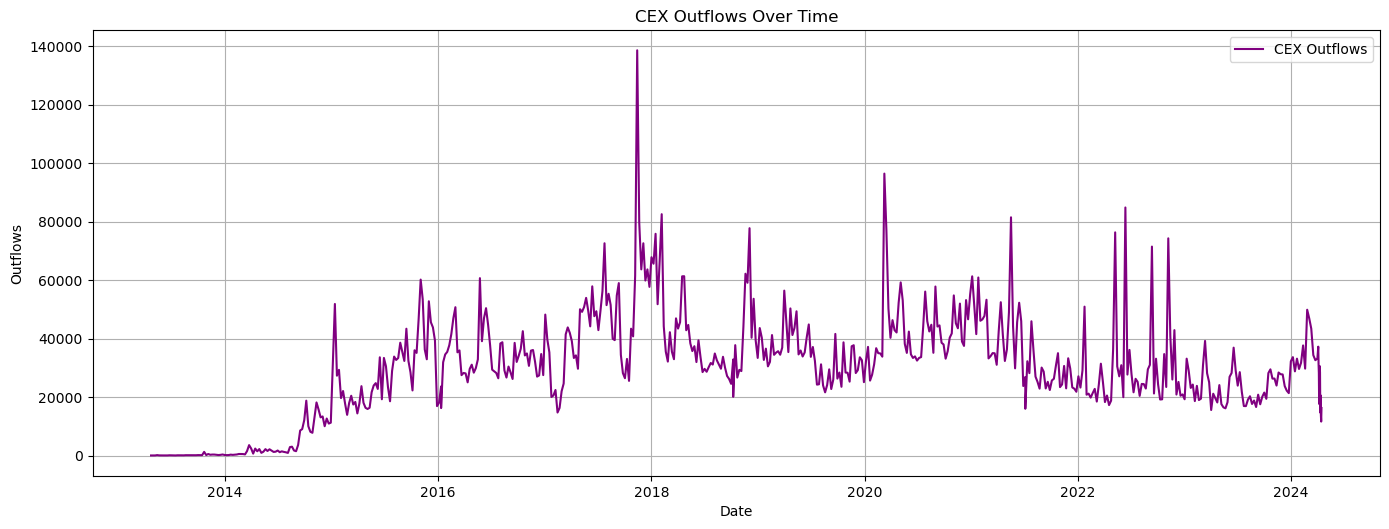

In [ ]:
#CEX OUTFLOWS

#DIPLAY DATAFRAME
btc_cex_outflows.drop(columns=['Price', 'Binance', 'Bitfinex', 'Bitstamp', 'Coinbase', 'Gemini', 'Huobi', 'Kraken', 'Luno', 'Okex', 'Poloniex'], inplace=True)
btc_cex_outflows.rename(columns={'Aggregated Exchanges': 'agg_cex_outflows'}, inplace=True)
btc_cex_outflows.dropna(inplace=True)
cex_outflows = btc_cex_outflows
display(cex_outflows)

# VISUALIZE THE DATA
cex_outflows_plot = plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 2)
plt.plot(cex_outflows.index, 
         cex_outflows['agg_cex_outflows'], 
         label='CEX Outflows', 
         color='purple')
plt.title('CEX Outflows Over Time')
plt.xlabel('Date')
plt.ylabel('Outflows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#APPEND TO FEATURES LIST
dataframes.append(cex_outflows)
feature_plots['cex_outflows'] = cex_outflows_plot

### Build Features Dataframe

In [ ]:
# DEFINE FUNCTIONS TO ALIGN, MERGE, DISPLAY, AND VISUALIZE DATAFRAME INFO

# ALIGN DATAFRAMES
def check_and_align_indices(dataframes):
    """
    Ensures all dataframes have unique and aligned datetime indices.
    Parameters:
    - dataframes (list of pd.DataFrame): List of dataframes to check and align.
    Returns:
    - list of pd.DataFrame: List of dataframes with ensured unique and aligned indices.
    """
    # ENSURE INDICES ARE UNIQUE AND DATETIME
    for i, df in enumerate(dataframes):
        if not df.index.is_unique:
            raise ValueError(f"Index of dataframe {i} is not unique.")
        if not pd.api.types.is_datetime64_any_dtype(df.index):
            raise TypeError(f"Index of dataframe {i} is not a datetime type.")
        
    # FIND COMMON INDEX
    common_index = dataframes[0].index
    for df in dataframes[1:]:
        common_index = common_index.intersection(df.index)
    if common_index.empty:
        raise ValueError("No common dates found across dataframes. Cannot align.")
    
    # REINDEX DATAFRAMES
    aligned_dataframes = [df.reindex(common_index) for df in dataframes]

    return aligned_dataframes

# MERGE DATAFRAMES
def merge_dataframes(aligned_dataframes):
    """
    Merges a list of dataframes into a single dataframe on their indices.
    Parameters:
    - aligned_dataframes: List of aligned dataframes to merge.
    Returns:
    - merged_df: The merged dataframe.
    """
    #START WITH FIRST DATAFRAME IN LIST
    merged_df = aligned_dataframes[0]

    # MERGE SUBSEQUENT DATAFRAMES INTO MERGED DATAFRAME
    for df in aligned_dataframes[1:]:
        merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='inner')
        
    return merged_df

# DISPLAY DATAFRAME INFO
def explore_data(merged_df):
    """
    Performs initial exploration on the provided dataframe to understand its structure,
    missing values, provides summary statistics and additional information.
    Parameters:
    - df (pd.DataFrame): The dataframe to explore.
    Returns:
    - None: Outputs exploration data to standard output.
    """
    # EXPLORE DATAFRAME____________
    print(f"Shape: {merged_df.shape}")
    print(f"Columns: {merged_df.columns}")
    print(f"Index: {merged_df.index.min()} to {merged_df.index.max()}")
    print(f"Data Types: {merged_df.dtypes}")
    print(f"Head: {merged_df.head()}")
    print(f"Tail: {merged_df.tail()}")

    # INFO__________________
    print(F"DataFrame Information: {merged_df.info()}")

    # SUMMARY______________________  
    print("\nSummary Statistics:")
    print(merged_df.describe())

    # MISSING VALUES_______________
    print("\nMissing Values:")
    missing_data = merged_df.isnull().sum()
    print(missing_data[missing_data > 0])
    
    # If missing values exist, handle them appropriately
    if missing_data.sum() > 0:

    # Option 1: Fill missing values with the median or mean
        # df.fillna(df.median(), inplace=True)

    # Option 2: Fill missing values using imputaton, interpolaton, forward/backeard filling
        # df.interpolate(method='linear', inplace=True)
        # df.fillna(method='ffill', inplace=True)
        # df.fillna(method='bfill', inplace=True)
        # df.fillna(method='pad', inplace=True)
    
    print("\nMissing values handled.")

# VISUALIZE DATAFRAME
def visualize_data(merged_df, col_index=0):
    """
    Generates visualizations for the dataframe to identify trends, distributions, and outliers.
    Parameters:
    - df (pd.DataFrame): The dataframe to visualize.
    Returns:
    - None: Outputs visualizations to standard output.
    """
    # List of key features to visualize
    features_to_visualize = merged_df.columns[col_index]  # Adjust as necessary based on specific features of interest

    # Time Series Plots
    for feature in features_to_visualize:
        plt.figure(figsize=(10, 4))
        plt.plot(merged_df.index, merged_df[feature], label=feature)
        plt.title(f'Time Series - {feature}')
        plt.xlabel('Date')
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Histograms
    merged_df[features_to_visualize].hist(bins=15, figsize=(15, 6), layout=(1, 4))
    plt.suptitle('Feature Distributions')
    plt.show()

    # Box Plots
    merged_df[features_to_visualize].plot(kind='box', figsize=(15, 6), subplots=True, layout=(1, 4))
    plt.suptitle('Feature Outliers')
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data_for_modeling(df, target_variable):
    """
    Prepares the dataset for modeling by selecting features, engineering features,
    and splitting the data into training and testing sets.
    Parameters:
    - df (pd.DataFrame): The dataframe to prepare.
    - target_variable (str): The name of the target variable.
    Returns:
    - X_train (pd.DataFrame): Training features.
    - X_test (pd.DataFrame): Testing features.
    - y_train (pd.Series): Training target.
    - y_test (pd.Series): Testing target.
    """
    # Feature selection
    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

# Example usage:
# X_train, X_test, y_train, y_test = prepare_data_for_modeling(merged_dataframe, 'TargetFeatureName')
